In [1]:
# particle_filter_example.ipynb
# February 16, 2021
# Tim Player playert@oregonstate.edu

In [2]:
from shapely.geometry import Point, Polygon
from StateEstimator import ParticleFilter
from World import World
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

### Define a 2D World containing an object.

In [3]:
# Define the shape, location, and angle of the object.
shape = Polygon([[0, 0], [6, 0], [6, 1],[0, 1], [0, 0]])
x = 1
y = 1
theta = np.pi/6

# Create a World object to store the map and do measurements.
map_size = (10,10) 
w = World(shape, x, y, theta, map_size)

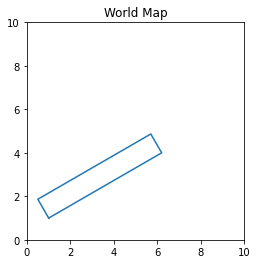

In [4]:
fig, ax = plt.subplots()
w.plot(ax)

### Run particle filter, prompting user for input

X coordinate to measure: 2
Y coordinate to measure: 2.1


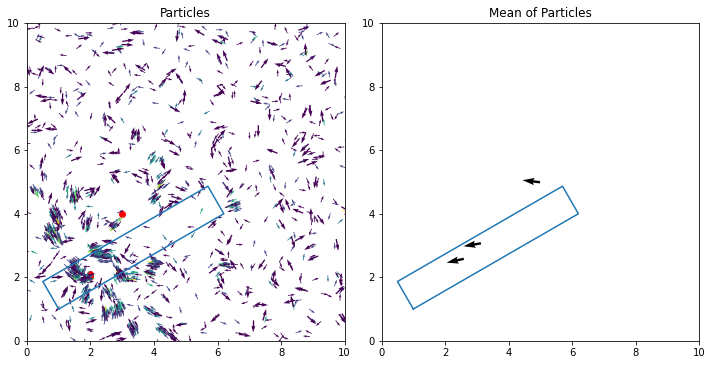

In [ ]:
# Make a particle  filter
pf = ParticleFilter(shape, 1000, map_size)

# Set up two plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 10))
w.plot(ax1)
w.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

# Repeatedly update the particle filter, measuring at user-defined locations.
i = 0
n = 1
while(True):
    # select random measurement
    x = float(input("X coordinate to measure:"))
    y = float(input("Y coordinate to measure:"))
    
    # update particle filter with measurement
    z = w.measure(x, y)
    pf.update(z)
    
    # Plot
    s = ax1.scatter(z[0], z[1], c='r')
    q = pf.draw_particles(ax1)
    
    x,y,t = pf.get_state() # access estimated state
    
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(0.01)

    if i != n-1:
        q.remove()
        s.remove()
"""
Make a SUPERMEGAset of candidate measurements.
For each particle that exists:
    Sample measurements that would prove or disprove it. (e.g., sample the border or interior)
    Add these measurements to the set of candidate measurements
    
At random, draw candidate measurements from the SUPERMEGAset of candidate measurements
"""

### Run particle filter, measuring randomly

In [5]:
# Make a particle  filter
n = 500 # run for n steps.
pf = ParticleFilter(shape, 1000, map_size)

# Set up two plots
fig = plt.figure(figsize=(10,5))
gs = GridSpec(nrows=3, ncols=3)

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[2,2])
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (5,5))
w.plot(ax1)
w.plot(ax2)
ax1.set_title('Particles')
ax2.set_title('Mean of Particles')
fig.tight_layout()

# Repeatedly update the particle filter, measuring randomly.
for i in range(n):
    # select random measurement
    x = np.random.uniform(0,map_size[0])
    y = np.random.uniform(0,map_size[1])
    
    # update particle filter with measurement
    z = w.measure(x, y)
    pf.update(z)
    
    # Plot
    s = ax1.scatter(z[0], z[1], c='r')
    q = pf.draw_particles(ax1)
    ax3.clear(); ax4.clear(); ax5.clear();
    h1, h2, h3 = pf.draw_histogram(ax3, ax4, ax5)
    
    x,y,t = pf.get_state() # access estimated state
    q2 = ax2.quiver(x, y, np.cos(t), np.sin(t), label='Estimate')
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(0.01)
    if i != n-1:
        q.remove()
        s.remove()

NameError: name 'GridSpec' is not defined

<Figure size 720x360 with 0 Axes>